# Dal Rae Customer Review Actionabilty 

## Import Required Libraries

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import requests
from bs4 import BeautifulSoup
import pandas as pd
import csv
import numpy as np

## Webscrape OpenTable for Reviews & Clean Data

In [2]:
# Extract Relevant OpenTable HTML data

user_agent = {'User-agent': 'Mozilla/5.0'}

def get_page_contents(url):
    page = requests.get(url, headers = user_agent)
    return BeautifulSoup(page.text, 'html.parser')

#Write Code to Get Total # of Reviews Here: ###

n = 1
names = []
ratings = []
reviews = []
for i in range(1,133):
    url = 'https://www.opentable.com/dal-rae?page='+str(n)+'&sortBy=lowestRating'
    soup = get_page_contents(url)
    for links in soup.find_all('p', class_='V0gqMM0V5nr33Ha56k83 cpEOy_DPrbjR6hnlY0ub'):
     name = links.get_text().strip()
     names.append(name)
    for links in soup.find_all('div', class_='Sssqfi7z0_YZugOpowNY'):
     score = links.get_text()
     ratings.append(score)
    for links in soup.find_all('span', class_='t9JcvSL3Bsj1lxMSi3pz h_kb2PFOoyZe1skyGiz9 DUkDy8G7CgNvYcWgJYPN'):
     review = links.get_text()
     reviews.append(review)
    n+=1

In [3]:
#OpenTable Data Cleaning

#Removes whitespace between each of our scraped reviews
proper_len = len(names)
for i in range(0,len(reviews)):
    if reviews[i] == '':
        reviews.remove(reviews[i])
    if len(reviews) == proper_len:
        break

#Removes Erronously scraped rating values, always two 4.8 values every time we scrape a new page
ratings_cleaned = []
for i in ratings:
    if i != '4.8':
        ratings_cleaned.append(i)

In [4]:
#Combination of Lists into OpenTable Dataframe
dalrae_opentable_dataset = pd.DataFrame(
    {'Names': names,
     'Ratings': ratings_cleaned,
     'Reviews': reviews
    })

In [5]:
#Saves OpenTable Dataset As a CSV
#dalrae_opentable_dataset.to_csv('dalrae_opentable_dataset.csv')

## Webscrape Yelp for Reviews & Clean Data

In [ ]:
## Extract Relevant Yelp HTML data
from selenium import webdriver
from selenium.webdriver.common.by import By
import time

user_agent = {'User-agent': 'Mozilla/5.0'}
def get_page_contents(url):
    page = requests.get(url, headers = user_agent)
    return BeautifulSoup(page.text, 'html.parser')

#Gets Total Number of Yelp Reviews
url = 'https://www.yelp.com/biz/dal-rae-restaurant-pico-rivera'
soup = get_page_contents(url)
total_number_reviews_yelp = soup.find('a', attrs={'class':'css-19v1rkv'}).string
total_number_reviews_yelp = int(re.findall('\d+', total_number_reviews_yelp)[0])
total_number_reviews_yelp

#Code for Yelp Reviews
driver = webdriver.Chrome('/Users/landonsmith/Downloads/chromedriver_mac_arm64/chromedriver')
driver.get('https://www.yelp.com/biz/dal-rae-restaurant-pico-rivera')
reviews = []
for i in range(0,1710,10):
    if i == 0:
        driver.get('https://www.yelp.com/biz/dal-rae-restaurant-pico-rivera')
    else: 
        driver.get('https://www.yelp.com/biz/dal-rae-restaurant-pico-rivera?start='+str(i))
    time.sleep(5)
    name_parents = driver.find_element(By.XPATH, "//div[starts-with(@class, ' margin-b2__09f24__CEMjT  border-color--default__09f24__NPAKY')]")
    name_child = name_parents.find_elements(By.XPATH, "//span[starts-with(@class, ' raw__09f24__T4Ezm')]")
    for i in name_child:
        reviews.append(i.text)


In [ ]:
#Yelp Data Cleaning

proper_len = 1707 
#Reviews Extra Strings Scraped along with Reviews
for i in range(0,1792):
    if reviews[i] == '$0.99+ delivery fee':
        reviews.remove(reviews[i])
    if reviews[i] == 'No Fees':
        reviews.remove(reviews[i])
    if reviews[i] == 'Pick up in 20-30 mins':
        reviews.remove(reviews[i])
    if reviews[i] == '$0 min':
        reviews.remove(reviews[i])
    if reviews[i] == '30-40 mins':
        reviews.remove(reviews[i])
    if reviews[i] == '9023 Washington Blvd':
        reviews.remove(reviews[i])
    if reviews[i] == 'Pico Rivera, CA 90660':
        reviews.remove(reviews[i])
    if 'miles away from' in reviews[i]:
        reviews.remove(reviews[i])
    if 'â\x80\x99' in reviews[i]:
        reviews[i]=reviews[i].replace('â\x80\x99',"'")
    if "\n" in reviews[i]:
        reviews[i]=reviews[i].replace("\n","")
    if "\'" in reviews[i]:
        reviews[i]=reviews[i].replace("\'","'")


In [ ]:
#Checks Reviews for Missed Extra Strings 
for i in range(0,len(reviews)):
    if len(reviews[i]) < 70:
        print(reviews[i])

In [ ]:
#Creates Yelp Reviews Dataset
yelp_reviews = reviews
dalrae_yelp_dataset = pd.DataFrame({'Reviews': yelp_reviews})

In [84]:
#Exports Yelp Reviews Dataset as a CSV
#dalrae_yelp_dataset.to_csv('dalrae_yelp_dataset.csv')

# OpenAI API - Determine Review Actionability

In [ ]:
#Determine If Reviews Are Actionable Using OpenAI API 
import pandas as pd
import openai
import time

openai.api_key = 'API KEY'

#Defines a function to check if a review is actionable
def are_reviews_actionable(batch):
    #Defines a system message to guide the model
    system_message = "You are an assistant that helps restaurant management. Restaurant mangement typically likes to read through negative reviews left by customers in order to help improve business operations. Some of these reviews contain enough information to be useful to restaurant management, but others are too vague to be actionable. For each review you are given, determine if the review is actionable."
    
    #Send the messages to the OpenAI API
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages= [
        {'role': 'system', 'content': system_message},
        {'role': 'user', 'content': 'Restaurant owners like to read through negative reviews  people give their restaurant online so that they can improve their business strategy. However, some reviews are too vague for the restaurant owner to know how to improve their business based off of the review. For the following three customer reviews, determine whether or not each review is specific enough to be actionable by restaurant management.'},
        {'role': 'user', 'content': 'First Review: '+batch.Reviews[0]},
        {'role': 'user', 'content': 'Second Review: '+batch.Reviews[1]},
        {'role': 'user', 'content': 'Third Review: '+batch.Reviews[2]},
        {'role': 'user', 'content': 'Fourth Review: '+batch.Reviews[3]},
        {'role': 'user', 'content': 'Fifth Review: '+batch.Reviews[4]},
        {'role': 'user', 'content': 'Based off of your previous determinations of actionability, return a binary value for each review that represents whether or not the review was actionable in the order that you processed them. Return 0 if the review was actionable and return 1 is the review was not actionable. Give me your answer in this format: First Decision:, Second Decision:, Third Decision:'}
    ]    
    )

    #Gets the model-generated reply
    reply = response['choices'][0]['message']['content']
    
    return reply

#Processes a maximum of 3 batches per minute (15 reviews processed per minute)
max_batches_per_minute = 3
batches_processed = 0
character_0 = '0'
character_1 = '1'

#Breaks Reviews Into Batches of 5
batches = [new_second_batch[i:i+5] for i in range(0, len(new_second_batch), 5)]
actionability_values = []

for batch in batches:
    reset_batch = batch.reset_index()
    raw_output = are_reviews_actionable(reset_batch)
    occurrences = []
    for index, char in enumerate(raw_output):
        if char == character_0:
            occurrences.append(index)
        if char == character_1:
            occurrences.append(index)
    results = []
    for i in occurrences:
        results.append(raw_output[i])
    print(results)
    actionability_values.append(results)
    batches_processed += 1
    if batches_processed >= max_batches_per_minute:
        # Pause for 60 seconds
        time.sleep(60)
        batches_processed = 0

In [ ]:
#Displays OpenAI Batch Results
actionability_values

#Determines Which Batches Had Misreads
length_5 = []
short = []
for index, char in enumerate(actionability_values):
    if len(char) == 5:
        length_5.append(index)
    if len(char) != 5:
        short.append(index)
        
len(actionability_values)
len(short)
short 

In [ ]:
#Defines a Function to calculate the Indices of Rows where there were Misreads        
def indices_calc(index):
    first_index = index * 5
    second_index = first_index + 5
    return first_index, second_index

#Computes the Indices of the Reviews Datasets that were Misread
incomplete_list = [288,329,341,364,376,391,413,429,438,439,450,460,466,473,513,515,548,557,562,572,581,583,597,599,600,649,658,678,681,682]
for i in incomplete_list:
    indices_calc(i)

In [ ]:
#Reruns Misread Reviews Through the OpenAI API
are_reviews_actionable(df[3410:3415].reset_index())

#Manually Corrects a Particular Misread Batch
actionability_values[288] = [1,1,0,0,0]

In [ ]:
#Flattens List of Responses for Insertion into Dataframe
flatten_list = [j for sub in actionability_values for j in sub]
len(flatten_list)

In [ ]:
#Inserts Results into New Column of Dataframe
new_batch2['actionable_value'] = flatten_list
new_batch2.actionable_value = pd.to_numeric(new_batch2.actionable_value)
new_batch2

In [ ]:
#Exports the Dataframe to CSV
#high_confidence.to_csv('high_confidence.csv')

## Descriptive Statistics On Cumulative Indentical Classification Dataset

In [ ]:
#Comparison of Different 1000 Review Test Trials
import pandas as pd
df1 = pd.read_csv('trial_1.csv')
df2 = pd.read_csv('trial_2.csv')
df3 = pd.read_csv('trial_3.csv')
df4 = pd.read_csv('trial_4.csv')
df5 = pd.read_csv('trial_5.csv')

#Compute Actionability Percentage for Each
action_1 = len(df1[df1.actionable_value==0])/len(df1)
action_2 = len(df2[df2.actionable_value==0])/len(df2)
action_3 = len(df3[df3.actionable_value==0])/len(df3)
action_4 = len(df4[df4.actionable_value==0])/len(df4)
action_5 = len(df5[df5.actionable_value==0])/len(df5)

df1 = df1.drop(columns='Unnamed: 0')
all_trials = df1.rename(columns={'actionable_value':'trial_1'})
all_trials['trial_2'] = df2.actionable_value
all_trials['trial_3'] = df3.actionable_value
all_trials['trial_4'] = df4.actionable_value
all_trials['trial_5'] = df5.actionable_value

#Compare Results Across Trials
#Trial 1 and 2 Similarity
sim1 = len(all_trials[all_trials.trial_1 == all_trials.trial_2])/len(all_trials)*100

#Trial 1, 2, & 3 Similarity
sim2 = len(all_trials[(all_trials.trial_1 == all_trials.trial_2) & (all_trials.trial_1 == all_trials.trial_3)])/len(all_trials)*100

#Trial 1, 2, 3, & 4 Similarity
sim3 = len(all_trials[(all_trials.trial_1 == all_trials.trial_2) & (all_trials.trial_1 == all_trials.trial_3) & (all_trials.trial_1 == all_trials.trial_4)])/len(all_trials)*100

#Trial 1, 2, 3, 4, 5 Similarity
sim4 = len(all_trials[(all_trials.trial_1 == all_trials.trial_2) & (all_trials.trial_1 == all_trials.trial_3) & (all_trials.trial_1 == all_trials.trial_4) & (all_trials.trial_1 == all_trials.trial_5)])/len(all_trials)*100

#Refine Dataset to Categorizations With Highest Confidence
high_confidence = all_trials[(all_trials.trial_1 == all_trials.trial_2) & (all_trials.trial_1 == all_trials.trial_3) & (all_trials.trial_1 == all_trials.trial_4) & (all_trials.trial_1 == all_trials.trial_5)]

,0
Trial 1,100.0
Trial 2,91.3
Trial 3,87.7
Trial 4,87.7
Trial 5,84.3


Text(0.5, 1.0, 'Identical Classifcation (Cumulative %)')

Text(0.5, 0, 'Trial Number')

Text(0, 0.5, 'Percentage Identical')

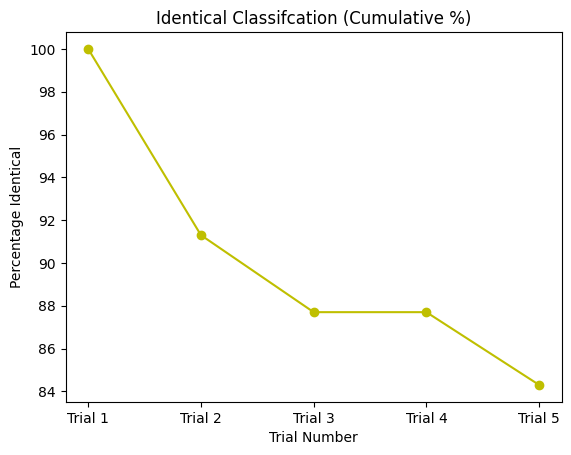

In [700]:
#Cumulative Indentical Classification Chart Creation
from matplotlib import pyplot as plt
trials = ['Trial 1','Trial 2','Trial 3','Trial 4','Trial 5']
cumulative_percentages = [100,sim1, sim2, sim3, sim4]

graph1 = pd.DataFrame(cumulative_percentages, trials)
graph1

plt.plot(trials,cumulative_percentages, c='y')
plt.scatter(trials,cumulative_percentages, c='y')
plt.title('Identical Classifcation (Cumulative %)')
plt.xlabel('Trial Number')
plt.ylabel('Percentage Identical')

# Data Manipulation: Splitting & Encoding 

In [85]:
reviews_sample = pd.DataFrame(pd.read_csv("high_confidence.csv"))
reviews_sample=reviews_sample.drop(columns=['Unnamed: 0','trial_2','trial_3','trial_4','trial_5'])
reviews_sample

,Reviews,trial_1
0,We have been going to Dal Rae for many years. ...,0
1,Very mediocre at best. Many other restaurants ...,1
2,Have been dining here at least once or twice a...,0
3,"This was Valentine's Day, and we were looking ...",0
4,Iâve been coming to Dal Rae for years. I wan...,0
...,...,...
838,6666666666666666666666666666666666666666666666...,1
839,We love the restaurant ! But we had to wait 55...,0
840,Food was amazing. Service like no other. Table...,1
841,Food is always amazing. Try new things every t...,1


In [87]:
from sklearn.model_selection import train_test_split
X = reviews_sample['Reviews']
y = reviews_sample['trial_1']

#Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train

642    Staff went out of her way to make sure we were...
728    Dressing up and dinning at the Del Rae is a gr...
300    Pros and cons seemed equal for my first visit....
789    The best for special occasions, and just plain...
759    The food was very good. The service was a litt...
                             ...                        
98     This was probably the worst experience we have...
322    The Dal Rae restaurant once noted as a fine di...
382    Had to wait almost 40 mins to be seated even t...
365    Del Rae over charged me for salads.  We had 6 ...
510    I have been coming to this restaurant for more...
Name: Reviews, Length: 674, dtype: object

In [88]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Initilization of tokenizer
tokenizer = Tokenizer(num_words=10000)

#Fitting
tokenizer.fit_on_texts(X_train)

#Converting the reviews to digits
sequences_tr = tokenizer.texts_to_sequences(X_train) #Gives unique integers to the words
sequences_te = tokenizer.texts_to_sequences(X_test) #Gives unique integers to the words

#Padding digits to have them scaled(Make them of equal length)
#max_length = 10000  # Maximum sequence length
#padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Check the results for the first review
print("Original review:", X_train[0])
print("Encoded sequence:", sequences_tr[0])
#print("Padded sequence:", padded_sequences[0])

Original review: We have been going to Dal Rae for many years. Never disappointed. However this visit was a very different experience.
First of all, the hosts were very accommodating. They sat us within 15 minutes although we arrived 45 minutes before our reservation time.
We were sat at the bar area. From the very beginning we felt like our server was rushing us to order. We ordered two pomegranate margaritas and it didnât taste like what we expected. So we asked to return it and got two glasses of Merlot instead. We can tell our server was not happy about it from her facial expression. We finished our food and we need some to go boxes. The bus person came and took our plates away in very rush manner and didnât even ask us where the untouched baked potato goes. He rushed the food to the packing area, packed and brought them back. We felt like we were rushing to leave the restaurant but it was only 9PM.
During our dinner, we had this couple sitting next to us. Apparently they were 

In [ ]:
#Decoding the sequences
word_index = tokenizer.word_index #Gives indexes

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [ ]:
decode_review = ' '.join([reverse_word_index.get(i,'?') for i in sequences_tr[0]]) #Take every number in the training data,look at the corresponding word or else if it doesn't exist add/ substitute it with a ? and join them with a space

In [92]:
import numpy as np
x_train_encoded = np.zeros((len(sequences_tr), 10000))
for i in range(len(sequences_tr)):
    x_train_encoded[i,sequences_tr[i]]=1
# Similarly for the test data
x_test_encoded = np.zeros((len(sequences_te), 10000))
for i in range(len(sequences_te)):
    x_test_encoded[i,sequences_te[i]]=1

# Logistic Regression

In [94]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(penalty='l2', C=0.1)
logreg.fit(x_train_encoded, y_train)

LogisticRegression(C=0.1)

Our training accuracy was: 0.9080118694362018
Our training precision was: 0.8582677165354331
Our training recall was: 0.8934426229508197
Our training F1 Score was: 0.8755020080321285
Our testing accuracy was: 0.7928994082840237
Our testing precision was: 0.8269230769230769
Our testing recall was: 0.6231884057971014
Our testing F1 Score was: 0.7107438016528926


0.8604347826086957

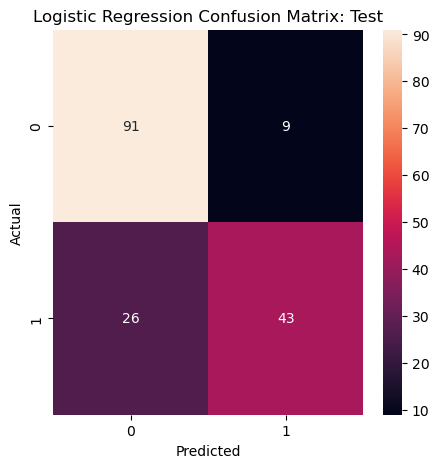

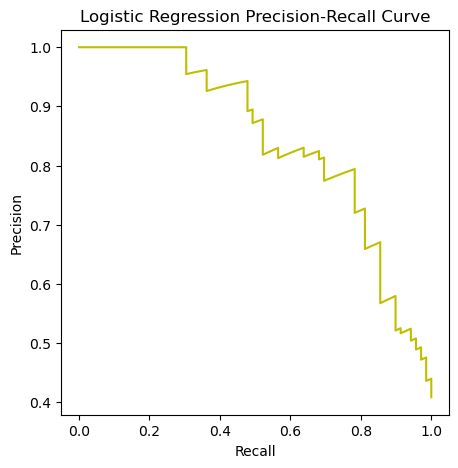

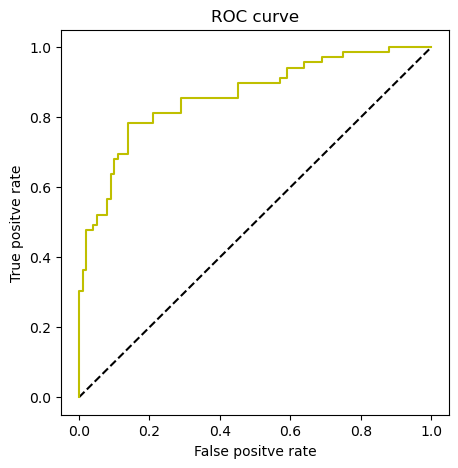

In [95]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, precision_recall_curve, roc_curve, auc, classification_report
import seaborn as sns
#Training Evaluation Metrics
y_train_pred = logreg.predict(x_train_encoded)
print('Our training accuracy was: ' +str(logreg.score(x_train_encoded, y_train)))
print('Our training precision was: ' + str(precision_score(y_train, y_train_pred)))
print('Our training recall was: ' + str(recall_score(y_train, y_train_pred)))
print('Our training F1 Score was: ' +str(f1_score(y_train, y_train_pred)))

#Test Evaluation Metrics
y_test_pred = logreg.predict(x_test_encoded)
print('Our testing accuracy was: ' +str(logreg.score(x_test_encoded, y_test)))
print('Our testing precision was: ' +str(precision_score(y_test, y_test_pred)))
print('Our testing recall was: ' +str(recall_score(y_test, y_test_pred)))
print('Our testing F1 Score was: ' +str(f1_score(y_test, y_test_pred)))
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True)
plt.title('Logistic Regression Confusion Matrix: Test')
plt.xlabel('Predicted')
plt.ylabel('Actual')

prob_test = logreg.predict_proba(x_test_encoded)
precision, recall, _ = precision_recall_curve(y_test, prob_test[:,1])
plt.figure(figsize=(5,5))
plt.plot(recall, precision,c='y')
plt.title('Logistic Regression Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

fpr, tpr, thresholds = roc_curve(y_test, prob_test[:,1])
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr,c='y')
plt.title('ROC curve')
plt.xlabel('False positve rate')
plt.ylabel('True positve rate')

auc(fpr, tpr)

# Random Forest

In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, precision_recall_curve, roc_curve, auc, classification_report
import seaborn as sns
rfc = RandomForestClassifier(n_estimators=1000, max_depth=17)
rfc.fit(x_train_encoded, y_train)
rfc_train_pred = rfc.predict(x_train_encoded)
rfc_test_pred = rfc.predict(x_test_encoded)
print(classification_report(y_train,rfc_train_pred))
print(classification_report(y_test,rfc_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       430
           1       0.93      1.00      0.96       244

    accuracy                           0.97       674
   macro avg       0.97      0.98      0.97       674
weighted avg       0.98      0.97      0.97       674

              precision    recall  f1-score   support

           0       0.77      0.92      0.84       100
           1       0.84      0.61      0.71        69

    accuracy                           0.79       169
   macro avg       0.81      0.76      0.77       169
weighted avg       0.80      0.79      0.79       169



Our training accuracy was: 0.973293768545994
Our training precision was: 0.9312977099236641
Our training recall was: 1.0
Our training F1 Score was: 0.9644268774703557
Our testing accuracy was: 0.7928994082840237
Our testing precision was: 0.84
Our testing recall was: 0.6086956521739131
Our testing F1 Score was: 0.7058823529411766
Our test AUC was: 0.856376811594203


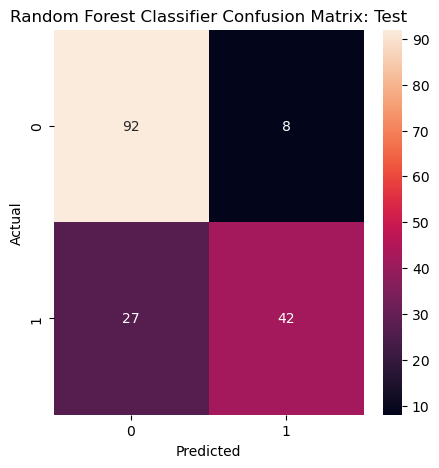

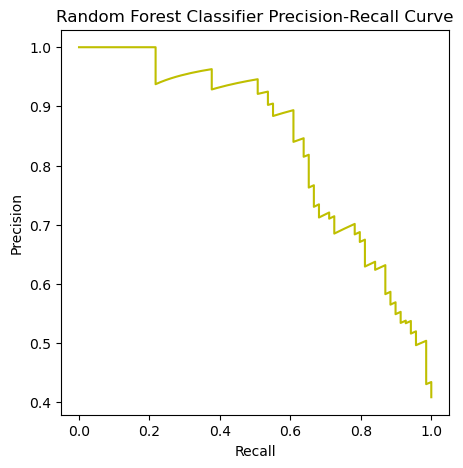

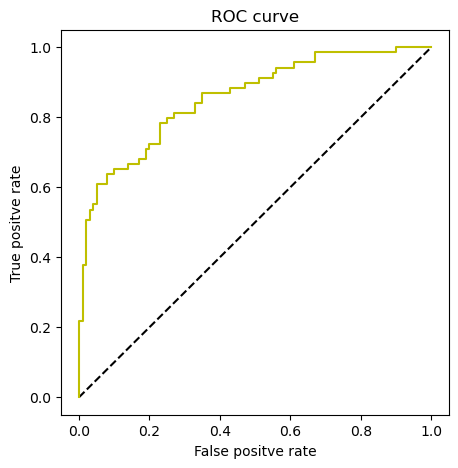

In [97]:
#Training Evaluation Metrics
print('Our training accuracy was: ' +str(rfc.score(x_train_encoded, y_train)))
print('Our training precision was: ' + str(precision_score(y_train, rfc_train_pred)))
print('Our training recall was: ' + str(recall_score(y_train, rfc_train_pred)))
print('Our training F1 Score was: ' +str(f1_score(y_train, rfc_train_pred)))

#Test Evaluation Metrics
print('Our testing accuracy was: ' +str(rfc.score(x_test_encoded, y_test)))
print('Our testing precision was: ' +str(precision_score(y_test, rfc_test_pred)))
print('Our testing recall was: ' +str(recall_score(y_test, rfc_test_pred)))
print('Our testing F1 Score was: ' +str(f1_score(y_test, rfc_test_pred)))
cm = confusion_matrix(y_test, rfc_test_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True)
plt.title('Random Forest Classifier Confusion Matrix: Test')
plt.xlabel('Predicted')
plt.ylabel('Actual')

prob_test = rfc.predict_proba(x_test_encoded)
precision, recall, _ = precision_recall_curve(y_test, prob_test[:,1])
plt.figure(figsize=(5,5))
plt.plot(recall, precision,c='y')
plt.title('Random Forest Classifier Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

fpr, tpr, thresholds = roc_curve(y_test, prob_test[:,1])
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr,c='y')
plt.title('ROC curve')
plt.xlabel('False positve rate')
plt.ylabel('True positve rate')

print('Our test AUC was: '+str(auc(fpr, tpr)))

# Deep Neural Network

In [98]:
#For sample data of 843
import tensorflow as tf
from keras import models
from keras import layers
from keras import regularizers

model = models.Sequential()
model.add(layers.Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.04), input_shape=(10000,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.04)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.04)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.04)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.04)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.04)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
model.save("model_dnn.h5")

In [99]:
history = model.fit(x_train_encoded, y_train, epochs=500, batch_size=500, validation_data=(x_test_encoded, y_test))

Epoch 1/500
2/2 [==============================] - 2s 533ms/step - loss: 47.8606 - auc_3: 0.5267 - val_loss: 43.4589 - val_auc_3: 0.7620
Epoch 2/500
2/2 [==============================] - 0s 110ms/step - loss: 42.8607 - auc_3: 0.5832 - val_loss: 39.0303 - val_auc_3: 0.8245
Epoch 3/500
2/2 [==============================] - 0s 94ms/step - loss: 38.5095 - auc_3: 0.6196 - val_loss: 35.2022 - val_auc_3: 0.8086
Epoch 4/500
2/2 [==============================] - 0s 79ms/step - loss: 34.7544 - auc_3: 0.6006 - val_loss: 31.9181 - val_auc_3: 0.8376
Epoch 5/500
2/2 [==============================] - 0s 78ms/step - loss: 31.5315 - auc_3: 0.6682 - val_loss: 29.1157 - val_auc_3: 0.8354
Epoch 6/500
2/2 [==============================] - 0s 79ms/step - loss: 28.7795 - auc_3: 0.7104 - val_loss: 26.7314 - val_auc_3: 0.8372
Epoch 7/500
2/2 [==============================] - 0s 72ms/step - loss: 26.4418 - auc_3: 0.7227 - val_loss: 24.7021 - val_auc_3: 0.8383
Epoch 8/500
2/2 [=============================

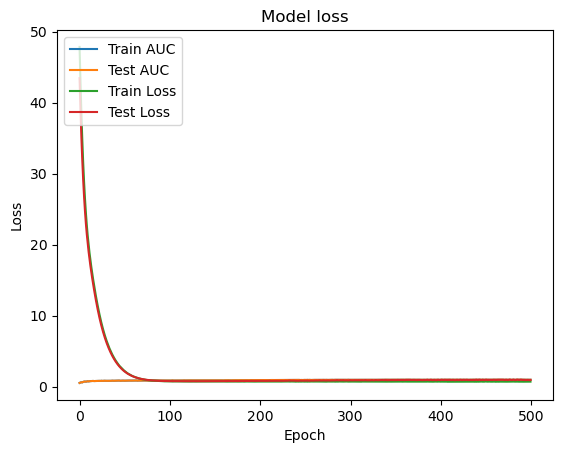

In [100]:
import matplotlib.pyplot as plt
%matplotlib inline
# Plot training & validation accuracy values
plt.plot(history.history['auc_3'])
plt.plot(history.history['auc_3'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train AUC', 'Test AUC', 'Train Loss', 'Test Loss' ], loc='upper left')
plt.show()

22/22 [==============================] - 0s 5ms/step - loss: 0.6796 - auc_3: 0.9868
Training accuracy is: 0.9867613315582275
Training precision is: 0.3620178041543027
Training recall is: 1.0
Training F1 Score is: 0.5315904139433552
22/22 [==============================] - 0s 4ms/step
Training AUC is: 0.9863419748379718
6/6 [==============================] - 0s 9ms/step - loss: 0.9358 - auc_3: 0.8533
Testing accuracy is: 0.8533333539962769
Testing precision is: 0.40828402366863903
Testing recall is: 1.0
Testing F1 Score is: 0.5798319327731092
6/6 [==============================] - 0s 4ms/step
Testing AUC is: 0.852608695652174
6/6 [==============================] - 0s 3ms/step


0.852608695652174

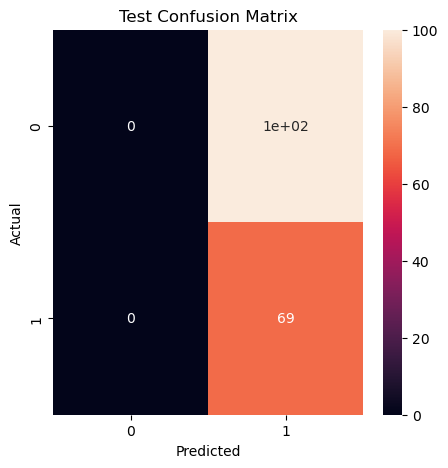

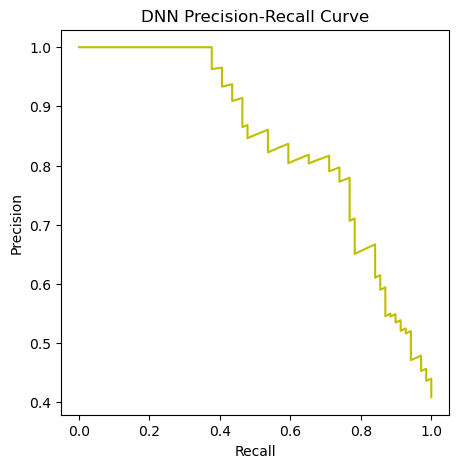

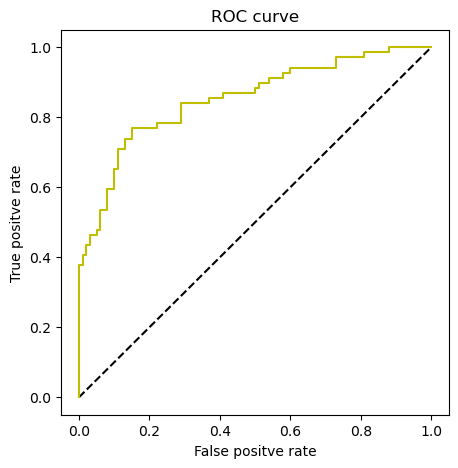

In [101]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, precision_recall_curve, roc_curve, auc, classification_report
import seaborn as sns
from matplotlib import pyplot as plt
#Training Evaluation Metrics
positive_prob = model.predict(x_train_encoded)>0 #model.predict equivalent to prob_test[:,1] in log reg
y_train_pred = positive_prob>0.5
print('Training accuracy is: ' +str(model.evaluate(x_train_encoded, y_train)[1]))
print('Training precision is: ' + str(precision_score(y_train, y_train_pred)))
print('Training recall is: ' + str(recall_score(y_train, y_train_pred)))
print('Training F1 Score is: ' +str(f1_score(y_train, y_train_pred)))
#AUC
pred_train = model.predict(x_train_encoded)
auc_train = roc_auc_score(y_train, pred_train)
print("Training AUC is:", auc_train)

#Test Evaluation Metrics
positive_prob = model.predict(x_test_encoded)>0 #model.predict equivalent to prob_test[:,1] in log reg
y_test_pred = positive_prob>0.5
print('Testing accuracy is: ' +str(model.evaluate(x_test_encoded, y_test)[1]))
print('Testing precision is: ' +str(precision_score(y_test, y_test_pred)))
print('Testing recall is: ' +str(recall_score(y_test, y_test_pred)))
print('Testing F1 Score is: ' +str(f1_score(y_test, y_test_pred)))
#AUC
pred_test = model.predict(x_test_encoded)
auc_test = roc_auc_score(y_test, pred_test)
print("Testing AUC is:", auc_test)
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True)
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

precision, recall, _ = precision_recall_curve(y_test, model.predict(x_test_encoded))
plt.figure(figsize=(5,5))
plt.plot(recall, precision,c='y')
plt.title('DNN Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

fpr, tpr, thresholds = roc_curve(y_test,model.predict(x_test_encoded))
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr,c='y')
plt.title('ROC curve')
plt.xlabel('False positve rate')
plt.ylabel('True positve rate')

auc(fpr, tpr)

In [99]:
#Loading a saved model
'''from tensorflow.keras.models import load_model

loaded_model = load_model("model_dnn.h5")
dataset_all = pd.DataFrame(pd.read_csv("high_confidence.csv"))
#pred_all = loaded_model.predict(dataset_all)
#pred_all

print(dataset_all["Reviews"].dtype)
dataset_all
'''

In [104]:
#DNN for 7060 records
dataset_full = pd.DataFrame(pd.read_csv("full_dal_rae_review_dataset.csv"))
dataset_full=dataset_full.drop(columns=['Unnamed: 0','Unnamed: 0.1'])
dataset_full

,Reviews,actionable_value
0,We have been going to Dal Rae for many years. ...,0
1,Very mediocre at best. Many other restaurants ...,1
2,Have been dining here at least once or twice a...,0
3,"This was Valentine's Day, and we were looking ...",0
4,Iâve been coming to Dal Rae for years. I wan...,0
...,...,...
7055,Having been dining at The Dal Rae for over 20 ...,1
7056,"Sorry to say the meat was not great quality, a...",0
7057,i love this place!!!great food--great atmosphe...,1
7058,"very delicious steaks, cooked to perfection ev...",0


In [105]:
from sklearn.model_selection import train_test_split
X = dataset_full['Reviews']
y = dataset_full['actionable_value']

#Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train

804     Dal Rae is a great steak house, we had the Pri...
2771    Fantastic service and food!  Dal Rae was my Da...
3682    Love this place. Our go to for nice dinner out...
6941    My dearly departed friend Kjell Nelson always ...
5061    My boyfriend has always wanted to go to Dal Ra...
                              ...                        
5218    Excellent food and great service. Even though ...
4060    Great as always. Service and food very good.  ...
1346    Lunch here is the best!  Ask for Dawn and you'...
3454    Such a lovely night! \n\nWe come to the Dal Ra...
3582                                         Always great
Name: Reviews, Length: 5648, dtype: object

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Initilization of tokenizer
tokenizer = Tokenizer(num_words=10000)

#Fitting
tokenizer.fit_on_texts(X_train)

#Converting the reviews to digits
sequences_tr = tokenizer.texts_to_sequences(X_train) #Gives unique integers to the words
sequences_te = tokenizer.texts_to_sequences(X_test) #Gives unique integers to the words

#Padding digits to have them scaled(Make them of equal length)
#max_length = 10000  # Maximum sequence length
#padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Check the results for the first review
print("Original review:", X_train[0])
print("Encoded sequence:", sequences_tr[0])
#print("Padded sequence:", padded_sequences[0])

In [ ]:
#Decoding the sequences
word_index = tokenizer.word_index #Gives indexes
print("Word Index:", word_index)

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
reverse_word_index

In [ ]:
decode_review = ' '.join([reverse_word_index.get(i,'?') for i in sequences_tr[0]]) #Take every number in the training data,look at the corresponding word or else if it doesn't exist add/ substitute it with a ? and join them with a space
decode_review

In [110]:
import numpy as np
x_train_encoded = np.zeros((len(sequences_tr), 10000))
for i in range(len(sequences_tr)):
    x_train_encoded[i,sequences_tr[i]]=1
# Similarly for the test data
x_test_encoded = np.zeros((len(sequences_te), 10000))
for i in range(len(sequences_te)):
    x_test_encoded[i,sequences_te[i]]=1

In [111]:
import tensorflow as tf
from keras import models
from keras import layers
from keras import regularizers

model = models.Sequential()
model.add(layers.Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.02), input_shape=(10000,)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
model.add(layers.Dropout(0.2)) 
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.02)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
model.save("model_dnn_full.h5")

In [112]:
history = model.fit(x_train_encoded, y_train, epochs=500, batch_size=500, validation_data=(x_test_encoded, y_test))

Epoch 1/500
12/12 [==============================] - 3s 103ms/step - loss: 19.0456 - auc_4: 0.7176 - val_loss: 13.6554 - val_auc_4: 0.8008
Epoch 2/500
12/12 [==============================] - 1s 50ms/step - loss: 11.4712 - auc_4: 0.7962 - val_loss: 9.2641 - val_auc_4: 0.8122
Epoch 3/500
12/12 [==============================] - 1s 47ms/step - loss: 8.1229 - auc_4: 0.8188 - val_loss: 6.7476 - val_auc_4: 0.8272
Epoch 4/500
12/12 [==============================] - 1s 49ms/step - loss: 5.8936 - auc_4: 0.8325 - val_loss: 4.8619 - val_auc_4: 0.8378
Epoch 5/500
12/12 [==============================] - 1s 47ms/step - loss: 4.2536 - auc_4: 0.8397 - val_loss: 3.5287 - val_auc_4: 0.8427
Epoch 6/500
12/12 [==============================] - 1s 51ms/step - loss: 3.1012 - auc_4: 0.8470 - val_loss: 2.6024 - val_auc_4: 0.8440
Epoch 7/500
12/12 [==============================] - 1s 44ms/step - loss: 2.3032 - auc_4: 0.8473 - val_loss: 1.9612 - val_auc_4: 0.8465
Epoch 8/500
12/12 [=========================

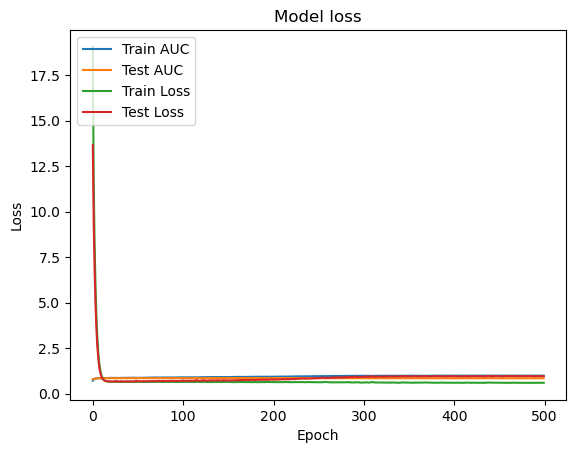

In [113]:
import matplotlib.pyplot as plt
%matplotlib inline
# Plot training & validation accuracy values
plt.plot(history.history['auc_4'])
plt.plot(history.history['val_auc_4'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train AUC', 'Test AUC', 'Train Loss', 'Test Loss' ], loc='upper left')
plt.show()

177/177 [==============================] - 1s 5ms/step - loss: 0.5666 - auc_4: 0.9975
Training accuracy is: 0.9975429177284241
Training precision is: 0.49610481586402266
Training recall is: 1.0
Training F1 Score is: 0.6631952662721894
177/177 [==============================] - 1s 3ms/step
Training AUC is: 0.9975543896714676
45/45 [==============================] - 0s 4ms/step - loss: 0.9635 - auc_4: 0.8468
Testing accuracy is: 0.8467743992805481
Testing precision is: 0.4801699716713881
Testing recall is: 1.0
Testing F1 Score is: 0.6488038277511962
45/45 [==============================] - 0s 7ms/step
Testing AUC is: 0.846772443394179
45/45 [==============================] - 0s 4ms/step


0.846772443394179

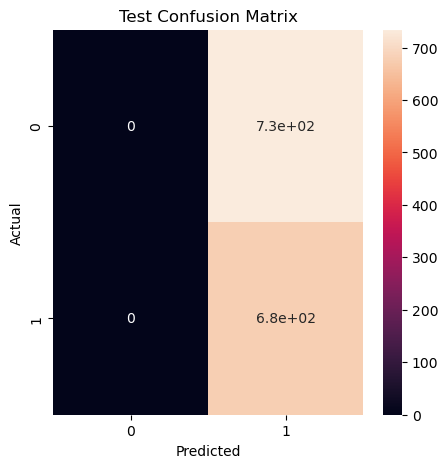

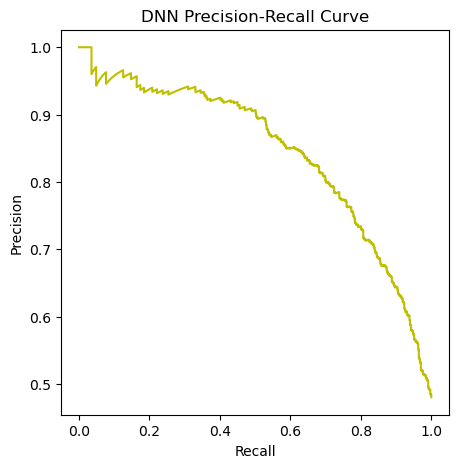

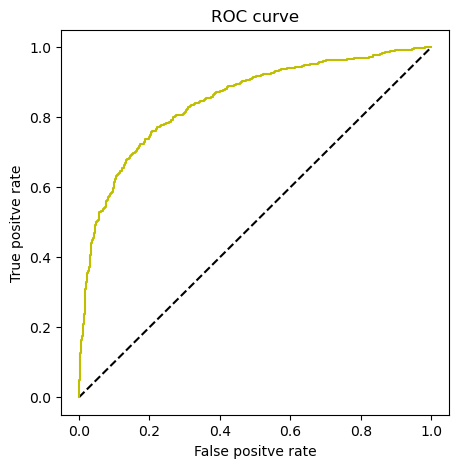

In [114]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, precision_recall_curve, roc_curve, auc, classification_report
import seaborn as sns
from matplotlib import pyplot as plt
#Training Evaluation Metrics
positive_prob = model.predict(x_train_encoded)>0 #model.predict equivalent to prob_test[:,1] in log reg
y_train_pred = positive_prob>0.5
print('Training accuracy is: ' +str(model.evaluate(x_train_encoded, y_train)[1]))
print('Training precision is: ' + str(precision_score(y_train, y_train_pred)))
print('Training recall is: ' + str(recall_score(y_train, y_train_pred)))
print('Training F1 Score is: ' +str(f1_score(y_train, y_train_pred)))
#AUC
pred_train = model.predict(x_train_encoded)
auc_train = roc_auc_score(y_train, pred_train)
print("Training AUC is:", auc_train)

#Test Evaluation Metrics
positive_prob = model.predict(x_test_encoded)>0 #model.predict equivalent to prob_test[:,1] in log reg
y_test_pred = positive_prob>0.5
print('Testing accuracy is: ' +str(model.evaluate(x_test_encoded, y_test)[1]))
print('Testing precision is: ' +str(precision_score(y_test, y_test_pred)))
print('Testing recall is: ' +str(recall_score(y_test, y_test_pred)))
print('Testing F1 Score is: ' +str(f1_score(y_test, y_test_pred)))
#AUC
pred_test = model.predict(x_test_encoded)
auc_test = roc_auc_score(y_test, pred_test)
print("Testing AUC is:", auc_test)
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True)
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

precision, recall, _ = precision_recall_curve(y_test, model.predict(x_test_encoded))
plt.figure(figsize=(5,5))
plt.plot(recall, precision,c='y')
plt.title('DNN Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

fpr, tpr, thresholds = roc_curve(y_test,model.predict(x_test_encoded))
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr,c='y')
plt.title('ROC curve')
plt.xlabel('False positve rate')
plt.ylabel('True positve rate')

auc(fpr, tpr)

## Topic Modelling - Latent Dirichlet Allocation(LDA)

In [118]:
#Loading a dataset,removing unwanted columns,removing punctuation from the reviews,converting the text to lowercase, and displays the modified dataset

#Loading the regular expression library
import pandas as pd
import re

dataset = pd.DataFrame(pd.read_csv("full_dal_rae_review_dataset.csv"))
dataset=dataset.drop(columns=['Unnamed: 0','Unnamed: 0.1'])

#Remove punctuation
dataset['reviews_text_processed'] = \
dataset['Reviews'].map(lambda x: re.sub('[,\.!?]', '', x))

#Removing single quotes
#dataset = [re.sub(r"\'", "", sent) for sent in dataset]

#Convert the titles to lowercase
dataset['reviews_text_processed'] = \
dataset['reviews_text_processed'].map(lambda x: x.lower())
dataset.head(10)

<>:12: DeprecationWarning: invalid escape sequence \.
<>:12: DeprecationWarning: invalid escape sequence \.
C:\Users\ayush\AppData\Local\Temp\ipykernel_57092\2924584890.py:12: DeprecationWarning: invalid escape sequence \.
  dataset['Reviews'].map(lambda x: re.sub('[,\.!?]', '', x))


,Reviews,actionable_value,reviews_text_processed
0,We have been going to Dal Rae for many years. ...,0,we have been going to dal rae for many years n...
1,Very mediocre at best. Many other restaurants ...,1,very mediocre at best many other restaurants i...
2,Have been dining here at least once or twice a...,0,have been dining here at least once or twice a...
3,"This was Valentine's Day, and we were looking ...",0,this was valentine's day and we were looking f...
4,Iâve been coming to Dal Rae for years. I wan...,0,iâve been coming to dal rae for years i want...
5,WHAT IS WRONG WITH THIS PLACE NOW? SERVICE WAS...,0,what is wrong with this place now service was ...
6,I have been your place many-many times but you...,1,i have been your place many-many times but you...
7,Had reservations 8 pm didnât get seated til ...,0,had reservations 8 pm didnât get seated til ...
8,Had to wait 25 minutes past reservation time t...,0,had to wait 25 minutes past reservation time t...
9,I went to this location expecting something co...,0,i went to this location expecting something co...


C:\Users\ayush\anaconda3\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


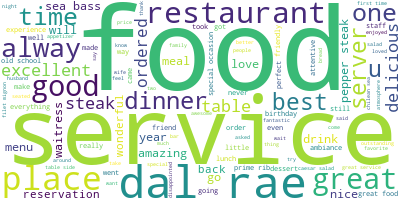

In [119]:
#Creating a word cloud,to get a visual representation of the most frequently occurring words in the processed reviews, 
#which can help in understanding the topics or themes present in the dataset.

#Import the wordcloud library
from wordcloud import WordCloud

#Join the different processed titles together.
long_string = ','.join(list(dataset['reviews_text_processed'].values))

#Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=10000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

#Visualize the word cloud
wordcloud.to_image()

In [117]:
#Preprocessing the data by tokenizing the sentences,converting them to lowercase, removing punctuation, and removing stopwords. 
#The resulting preprocessed text data is stored in the data_words list.
#(Can remove this chunk)
'''
import gensim #Library for topic modeling and NLP
from gensim.utils import simple_preprocess #For stopword and tokenization
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'use']) #Add additional words that are not useful

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


data = dataset.reviews_text_processed.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['going', 'dal', 'rae', 'many', 'years', 'never', 'disappointed', 'however', 'visit', 'different', 'experience', 'first', 'hosts', 'accommodating', 'sat', 'us', 'within', 'minutes', 'although', 'arrived', 'minutes', 'reservation', 'time', 'sat', 'bar', 'area', 'beginning', 'felt', 'like', 'server']


In [120]:
#Creating a dictionary of words from the preprocessed text data, converts the preprocessed texts into a document-term matrix using the bag-of-words 
#representation, and displaying some elements of the bag-of-words representation for the first review in the corpus.

#By representing documents as BoW vectors, topic modeling algorithms can identify patterns of word co-occurrence and predict topics based on the 
#distribution of words across reviews.

import gensim.corpora as corpora

#Create Dictionary
id2word = corpora.Dictionary(data_words)

#Create Corpus
texts = data_words

#Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

#View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 3), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [121]:
#LDA Model
#Display the top keywords for each of the identified topics in the LDA model.The doc_lda variable will capture the interpreted topic distribution for each 
#review in the corpus based on the trained model.

from pprint import pprint
num_topics = 5 #Number of topics

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

#Keywords for top n topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.011*"time" + 0.011*"food" + 0.009*"good" + 0.008*"service" + '
  '0.008*"place" + 0.008*"great" + 0.008*"us" + 0.007*"table" + '
  '0.007*"restaurant" + 0.006*"steak"'),
 (1,
  '0.025*"food" + 0.021*"great" + 0.020*"service" + 0.012*"time" + 0.009*"dal" '
  '+ 0.008*"rae" + 0.008*"steak" + 0.007*"good" + 0.007*"back" + '
  '0.007*"place"'),
 (2,
  '0.014*"rae" + 0.013*"food" + 0.012*"steak" + 0.011*"dal" + 0.010*"service" '
  '+ 0.010*"good" + 0.010*"dinner" + 0.008*"great" + 0.007*"place" + '
  '0.007*"best"'),
 (3,
  '0.024*"service" + 0.024*"food" + 0.017*"great" + 0.011*"always" + '
  '0.009*"place" + 0.009*"excellent" + 0.009*"restaurant" + 0.009*"dal" + '
  '0.008*"rae" + 0.007*"steak"'),
 (4,
  '0.015*"food" + 0.015*"rae" + 0.015*"dal" + 0.013*"great" + 0.013*"service" '
  '+ 0.012*"place" + 0.010*"good" + 0.008*"always" + 0.008*"restaurant" + '
  '0.007*"years"')]


In [122]:
#A function to perform lemmatize and stem preprocessing steps on the data set.
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

#import nltk
#nltk.download('omw-1.4')


In [123]:
#Preprocess the reviews by lemmatizing and stemming, saving the results as ‘processed_review’
processed_review = dataset['Reviews'].map(preprocess)
processed_review[:10]

0    [go, year, disappoint, visit, differ, experi, ...
1    [mediocr, best, restaur, spend, better, better...
2    [din, twice, year, year, decid, lunch, tradit,...
3    [valentin, look, forward, dinner, disappoint, ...
4    [come, year, want, galentin, dinner, close, gi...
5    [wrong, place, servic, host, give, hour, say, ...
6    [place, time, servic, night, disappoint, appoi...
7           [reserv, didnâ, seat, dinner, noisi, area]
8    [wait, minut, past, reserv, time, seat, remind...
9    [go, locat, expect, compar, water, grill, pric...
Name: Reviews, dtype: object

In [124]:
#Bag of Words on the Data set that stores the word to ID mapping and frequencies.
#Create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set.

dictionary = gensim.corpora.Dictionary(processed_review)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 accommod
1 appar
2 area
3 arriv
4 ask
5 away
6 bake
7 begin
8 box
9 bring
10 clearli


In [125]:
#Gensim filter_extremes
#Applying this filter to reduces the dictionary size by removing infrequent and too frequent words, which can help improve the efficiency 
#and quality of the subsequent topic modeling process.

#Filter out tokens that appear in

#less than 15 documents (absolute number) or
#more than 0.5 documents (fraction of total corpus size, not absolute number).
#after the above two steps, keep only the first 10000 most frequent tokens.

dictionary.filter_extremes(no_below=10, keep_n=10000)

In [126]:
#Gensim doc2bow
#For each document we create a dictionary reporting how many words and how many times those words appear. 
#Save this to ‘bow_corpus’, then check our selected document earlier.

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_review]
bow_corpus[10]

[(20, 1),
 (32, 1),
 (39, 3),
 (44, 1),
 (47, 1),
 (52, 2),
 (61, 1),
 (62, 1),
 (67, 1),
 (72, 1),
 (90, 1),
 (96, 1),
 (97, 1),
 (108, 4),
 (189, 1),
 (201, 1),
 (205, 1),
 (206, 1),
 (207, 1),
 (208, 2),
 (209, 1),
 (210, 1),
 (211, 1),
 (212, 1),
 (213, 1),
 (214, 1),
 (215, 1),
 (216, 2),
 (217, 1),
 (218, 1),
 (219, 1),
 (220, 1),
 (221, 1),
 (222, 1),
 (223, 1),
 (224, 1),
 (225, 1),
 (226, 1),
 (227, 1),
 (228, 1),
 (229, 1),
 (230, 1),
 (231, 1),
 (232, 1),
 (233, 1)]

In [127]:
#Preview Bag Of Words for our sample preprocessed review.
#Display the word ID, word, and frequency count for each word in the Bag-of-Words representation of the specified review.
#This provides an insight into the word occurrences in the review and their corresponding representations in the Bag-of-Words model.

bow_doc_10 = bow_corpus[10]
for i in range(len(bow_doc_10)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_10[i][0], 
                                               dictionary[bow_doc_10[i][0]], 
bow_doc_10[i][1]))

Word 20 ("expect") appears 1 time.
Word 32 ("like") appears 1 time.
Word 39 ("order") appears 3 time.
Word 44 ("potato") appears 1 time.
Word 47 ("restaur") appears 1 time.
Word 52 ("staff") appears 2 time.
Word 61 ("best") appears 1 time.
Word 62 ("better") appears 1 time.
Word 67 ("spend") appears 1 time.
Word 72 ("filet") appears 1 time.
Word 90 ("wait") appears 1 time.
Word 96 ("menu") appears 1 time.
Word 97 ("place") appears 1 time.
Word 108 ("drink") appears 4 time.
Word 189 ("good") appears 1 time.
Word 201 ("salad") appears 1 time.
Word 205 ("cesar") appears 1 time.
Word 206 ("chop") appears 1 time.
Word 207 ("classic") appears 1 time.
Word 208 ("cocktail") appears 2 time.
Word 209 ("cucumb") appears 1 time.
Word 210 ("dark") appears 1 time.
Word 211 ("desir") appears 1 time.
Word 212 ("especi") appears 1 time.
Word 213 ("friendli") appears 1 time.
Word 214 ("fullerton") appears 1 time.
Word 215 ("gener") appears 1 time.
Word 216 ("hard") appears 2 time.
Word 217 ("help") appe

In [128]:
#TF-IDF 
#TF-IDF assigns weights to words based on their frequency in the review and inverse review frequency, providing a numerical representation 
#that highlights the importance of words in the context of the corpus.

#Printing the TF-IDF representation for the first review in the corpus.
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.11023553572219921),
 (1, 0.14877261069980088),
 (2, 0.14785455944740789),
 (3, 0.08501250539114924),
 (4, 0.07890483475259932),
 (5, 0.09155602645441),
 (6, 0.0911516207057984),
 (7, 0.1159886163460551),
 (8, 0.15831298558192028),
 (9, 0.07610862058820113),
 (10, 0.14187326420990629),
 (11, 0.09248168139910758),
 (12, 0.09838395239836112),
 (13, 0.08873121971910052),
 (14, 0.36479534589634643),
 (15, 0.09428040055170489),
 (16, 0.04812460762242401),
 (17, 0.05756856813799691),
 (18, 0.05860948833229234),
 (19, 0.07874105557228765),
 (20, 0.07874105557228765),
 (21, 0.04764619137217739),
 (22, 0.15471542818852943),
 (23, 0.19332271979813107),
 (24, 0.10101291428507889),
 (25, 0.11110753117944859),
 (26, 0.10095454953827951),
 (27, 0.10439819043303313),
 (28, 0.09196704403331861),
 (29, 0.085541788419738),
 (30, 0.11201086243985124),
 (31, 0.0813173708822758),
 (32, 0.15024781183080277),
 (33, 0.08016841804617802),
 (34, 0.22341226250209986),
 (35, 0.14187326420990629),
 (36, 0.15

In [129]:
#Approach 1
#Running LDA using Bag of Words
#Train lda model using gensim.models.LdaMulticor
#For each topic, we will explore the words occuring in that topic and its relative weight.

lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=7, id2word=dictionary, passes=2, workers=2)
# - Focuses on the word occurrences in the corpus
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.020*"servic" + 0.014*"good" + 0.012*"time" + 0.011*"steak" + 0.011*"tabl" + 0.010*"salad" + 0.009*"bread" + 0.009*"come" + 0.009*"bass" + 0.009*"place"
Topic: 1 
Words: 0.021*"servic" + 0.019*"good" + 0.019*"steak" + 0.018*"place" + 0.017*"come" + 0.013*"excel" + 0.012*"tabl" + 0.011*"pepper" + 0.010*"time" + 0.009*"great"
Topic: 2 
Words: 0.020*"time" + 0.019*"steak" + 0.018*"good" + 0.017*"place" + 0.016*"great" + 0.015*"order" + 0.011*"restaur" + 0.011*"like" + 0.010*"tabl" + 0.009*"salad"
Topic: 3 
Words: 0.034*"great" + 0.027*"servic" + 0.021*"place" + 0.019*"steak" + 0.013*"love" + 0.012*"amaz" + 0.012*"best" + 0.011*"restaur" + 0.011*"go" + 0.009*"come"
Topic: 4 
Words: 0.017*"time" + 0.015*"din" + 0.014*"restaur" + 0.013*"steak" + 0.013*"place" + 0.013*"like" + 0.011*"servic" + 0.011*"meal" + 0.010*"good" + 0.010*"nice"
Topic: 5 
Words: 0.028*"servic" + 0.018*"great" + 0.018*"good" + 0.017*"time" + 0.015*"restaur" + 0.014*"order" + 0.012*"come" + 0.012*"wait"

In [130]:
##Approach 2
#Running LDA using TF-IDF
# - Considers the importance of terms based on their frequency and rarity in the corpus

#distinguish different topics using the words in each topic and their corresponding weights

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=7, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.027*"great" + 0.014*"amaz" + 0.013*"place" + 0.012*"servic" + 0.012*"wonder" + 0.010*"experi" + 0.009*"favorit" + 0.009*"good" + 0.008*"restaur" + 0.008*"time"
Topic: 1 Word: 0.012*"great" + 0.010*"server" + 0.009*"servic" + 0.009*"wonder" + 0.009*"excel" + 0.008*"love" + 0.008*"time" + 0.008*"din" + 0.007*"meal" + 0.007*"disappoint"
Topic: 2 Word: 0.013*"great" + 0.011*"restaur" + 0.011*"servic" + 0.011*"birthday" + 0.010*"best" + 0.010*"love" + 0.009*"dinner" + 0.009*"outstand" + 0.009*"place" + 0.009*"awesom"
Topic: 3 Word: 0.008*"good" + 0.007*"great" + 0.007*"steak" + 0.007*"servic" + 0.006*"special" + 0.006*"place" + 0.006*"disappoint" + 0.006*"come" + 0.006*"excel" + 0.006*"occas"
Topic: 4 Word: 0.023*"excel" + 0.013*"servic" + 0.009*"great" + 0.009*"steak" + 0.008*"love" + 0.008*"place" + 0.008*"good" + 0.006*"amaz" + 0.006*"time" + 0.006*"birthday"
Topic: 5 Word: 0.010*"great" + 0.009*"excel" + 0.009*"experi" + 0.008*"time" + 0.008*"servic" + 0.007*"enjoy" + 0

In [131]:
#Displays the score of the topic and the top 10 most representative words for that topic to understand the main theme \

for index, score in sorted(lda_model[bow_corpus[10]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))
    
print("For TF-IDF")

for index, score in sorted(lda_model_tfidf[bow_corpus[10]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.3734433948993683	 
Topic: 0.028*"servic" + 0.018*"great" + 0.018*"good" + 0.017*"time" + 0.015*"restaur" + 0.014*"order" + 0.012*"come" + 0.012*"wait" + 0.011*"experi" + 0.010*"dinner"

Score: 0.360287606716156	 
Topic: 0.020*"time" + 0.019*"steak" + 0.018*"good" + 0.017*"place" + 0.016*"great" + 0.015*"order" + 0.011*"restaur" + 0.011*"like" + 0.010*"tabl" + 0.009*"salad"

Score: 0.2556394934654236	 
Topic: 0.017*"time" + 0.015*"din" + 0.014*"restaur" + 0.013*"steak" + 0.013*"place" + 0.013*"like" + 0.011*"servic" + 0.011*"meal" + 0.010*"good" + 0.010*"nice"
For TF-IDF

Score: 0.8874298334121704	 
Topic: 0.023*"excel" + 0.013*"servic" + 0.009*"great" + 0.009*"steak" + 0.008*"love" + 0.008*"place" + 0.008*"good" + 0.006*"amaz" + 0.006*"time" + 0.006*"birthday"

Score: 0.060180824249982834	 
Topic: 0.008*"good" + 0.007*"great" + 0.007*"steak" + 0.007*"servic" + 0.006*"special" + 0.006*"place" + 0.006*"disappoint" + 0.006*"come" + 0.006*"excel" + 0.006*"occas"

Score: 0.0417547

In [132]:
#model perplexity - Lower values indicated the model is good
perplexity = lda_model.log_perplexity(bow_corpus)
print("Perplexity: ", perplexity)

Perplexity:  -6.482939900258825


In [133]:
#Model Evaluation - Coherence
from gensim.models import CoherenceModel

#Coherence score using the entire corpus
coherence_model = CoherenceModel(
    model=lda_model, texts=processed_review, dictionary=dictionary, coherence='c_v'
)
coherence_score = coherence_model.get_coherence()

print("Coherence Score of normal model: {:.4f}".format(coherence_score))

#Coherence score using the entire corpus of tfidf
coherence_model = CoherenceModel(
    model=lda_model_tfidf, texts=processed_review, dictionary=dictionary, coherence='c_v'
)
coherence_score_tf = coherence_model.get_coherence()

print("Coherence Score of TF-IDF model: {:.4f}".format(coherence_score_tf))

print("As the coherence of TF-IDF is less, we are discarding this method.")

Coherence Score of normal model: 0.4731
Coherence Score of TF-IDF model: 0.3887
As the coherence of TF-IDF is less, we are discarding this method.


In [134]:
#Visualization
import pyLDAvis.gensim_models as gensimvis
import pickle
import pyLDAvis
import os

# Create the directory if it doesn't exist
os.makedirs('./results/', exist_ok=True)

# Specify the file path
LDAvis_data_filepath = './results/ldavis_prepared_5'

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_5')

# Subset of the data for visualization
subset_corpus = bow_corpus[:1000]  # Adjust the subset size as per your needs

# If this is a bit time-consuming - make the if statement True
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, subset_corpus, dictionary, sort_topics=False)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# Load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

# Display the visualization
pyLDAvis.display(LDAvis_prepared)


In [135]:
#Interpretetion 
    
#Labels to each topic based on <>
topic_labels = {
    0: 'Dining Frequency',
    1: 'Special Occasion',
    2: 'Steak and Salads',
    3: 'Food Items Overall',
    4: 'Positive feedbacks and Services ',
    5: 'Staff',
    6: 'Negative feedbacks'
}

#Labeled topics
for topic_idx, topic_words in lda_model.print_topics(-1):
    print('Topic {}: {}'.format(topic_idx, topic_labels[topic_idx]))
    print('Top Words: {}'.format(topic_words))

Topic 0: Dining Frequency
Top Words: 0.020*"servic" + 0.014*"good" + 0.012*"time" + 0.011*"steak" + 0.011*"tabl" + 0.010*"salad" + 0.009*"bread" + 0.009*"come" + 0.009*"bass" + 0.009*"place"
Topic 1: Special Occasion
Top Words: 0.021*"servic" + 0.019*"good" + 0.019*"steak" + 0.018*"place" + 0.017*"come" + 0.013*"excel" + 0.012*"tabl" + 0.011*"pepper" + 0.010*"time" + 0.009*"great"
Topic 2: Steak and Salads
Top Words: 0.020*"time" + 0.019*"steak" + 0.018*"good" + 0.017*"place" + 0.016*"great" + 0.015*"order" + 0.011*"restaur" + 0.011*"like" + 0.010*"tabl" + 0.009*"salad"
Topic 3: Food Items Overall
Top Words: 0.034*"great" + 0.027*"servic" + 0.021*"place" + 0.019*"steak" + 0.013*"love" + 0.012*"amaz" + 0.012*"best" + 0.011*"restaur" + 0.011*"go" + 0.009*"come"
Topic 4: Positive feedbacks and Services 
Top Words: 0.017*"time" + 0.015*"din" + 0.014*"restaur" + 0.013*"steak" + 0.013*"place" + 0.013*"like" + 0.011*"servic" + 0.011*"meal" + 0.010*"good" + 0.010*"nice"
Topic 5: Staff
Top Word

In [41]:
'''#Tagging - For new reviews
new_review = preprocess(new_review_text) #new_review_text--> New reviews added
new_BoW = dictionary.doc2bow(new_review)  #Convert new document to bag-of-words
topic_distribution = lda_model.get_document_topics(new_BoW) 


topic_tags = []
for topic in topic_distribution:
    topic_id, topic_prob = topic
    topic_tags.append((topic_id, lda_model.print_topic(topic_id)))  #Appending topic id and corresponding topic keywords'''

'#Tagging - For new reviews\nnew_review = preprocess(new_review_text) #new_review_text--> New reviews added\nnew_BoW = dictionary.doc2bow(new_review)  #Convert new document to bag-of-words\ntopic_distribution = lda_model.get_document_topics(new_BoW) \n\n\ntopic_tags = []\nfor topic in topic_distribution:\n    topic_id, topic_prob = topic\n    topic_tags.append((topic_id, lda_model.print_topic(topic_id)))  #Appending topic id and corresponding topic keywords'

In [136]:
#Fetching the top words for each topic
topic_summaries = []
for idx, topic in lda_model.print_topics(-1):
    words = topic.split("+")
    top_words = [word.split("*")[1].replace('"', '').strip() for word in words][:5]  # Get the top 5 words
    summary = " ".join(top_words)  # Combine the top words into a summary
    topic_summaries.append(summary)

#Topic Summaries
for idx, summary in enumerate(topic_summaries):
    print("Topic {}: {}".format(idx, summary))


Topic 0: servic good time steak tabl
Topic 1: servic good steak place come
Topic 2: time steak good place great
Topic 3: great servic place steak love
Topic 4: time din restaur steak place
Topic 5: servic great good time restaur
Topic 6: great servic restaur love place


In [137]:
# Fetching the top words for each topic
topic_summaries = []
for idx, topic in lda_model.print_topics(-1):
    words = topic.split("+")
    top_words = [word.split("*")[1].replace('"', '').strip() for word in words][:5]  # Get the top 5 words
    summary = " ".join(top_words)  # Combine the top words into a summary
    topic_summaries.append(summary)

# Topic Summaries
for idx, summary in enumerate(topic_summaries):
    print("Topic {}: {}".format(idx, summary))

Topic 0: servic good time steak tabl
Topic 1: servic good steak place come
Topic 2: time steak good place great
Topic 3: great servic place steak love
Topic 4: time din restaur steak place
Topic 5: servic great good time restaur
Topic 6: great servic restaur love place
